<a href="https://colab.research.google.com/github/intheblueside/machine_learning_projects/blob/phishing/phishing_detection/phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing Site Predictor

The increasing use of the Internet has led to a new way of stealing data, known as cybercrime. Cybercrime refers to stealing private information and violating privacy through computers. The primary technique used is phishing.

Phishing attacks are fraudulent emails, text message, phone calls, or websites that are designed to trick users into actions like downloading malware, sharing sensitive information or personal data, or any other actions that expose themselves or their organisations to cybercrime.

This work aims to provide a solution for detecting potential phishing website links with the help of machine learning algorithms focused on the behaviors and qualities of the suggested URL.

### Import Libraries

In [ ]:
pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix
import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics
import matplotlib.pyplot as plt # provide object-oriented API for embedding plots into applications
import string # for EDA - special character count

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup # used for scraping websites, that is, extracting data from websites
from selenium import webdriver # used to automate user interactions with webpages (e.g. repetitive tasks such as form filling)
import networkx as nx # for network graphing purposes

## O: OBTAIN

### Loading Dataset

In [ ]:
phish_data = pd.read_csv('phishing_site_urls.csv')

### Getting to Know the Data

In [ ]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [ ]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


About the dataset:
- dataset contains 549,346 entries
- there are two columns:
    - URL column containing the website urls
    - Label column containing website url categorisation: good (not a phishing site link) or bad (is a phishing site link)

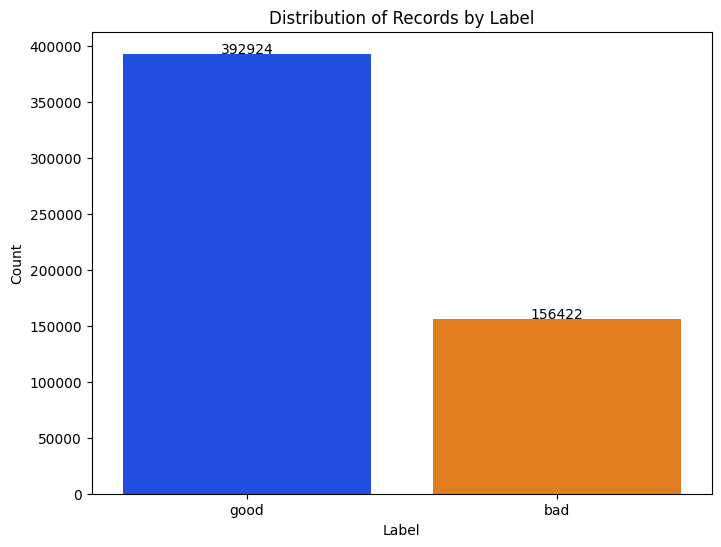

In [ ]:
# Count occurence of records for each category in Label column
label_counts = phish_data['Label'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='bright', legend=False)

# Add count values on top of each bar with corresponding color
for i, (index, value) in enumerate(label_counts.items()):
    barplot.text(x=i, y=value + 0.1, s=value, ha='center', color='black')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Records by Label')

# Show the plot
plt.show()

## S: SCRUB

### Missing Values

In [ ]:
phish_data.isnull().sum()

URL      0
Label    0
dtype: int64

- There is no missing value in the dataset

### Unifying Labels / Fixing Up Formats

In [ ]:
phish_data.sample(20)

,URL,Label
210002,lynettescrafts.blogspot.com/,good
38057,pastehtml.com/view/cjrz207ju.html,bad
169161,en.academic.ru/dic.nsf/military/2356/half,good
326855,facebook.com/craig.kilborn,good
10979,wa67g887z.homepage.t-online.de/dhjhjshs/login.htm,bad
423828,roadsideamerica.com/hotels_motels/hotelinfo/13...,good
469041,yellowpages.com/south-haven-mi/rovers-retreat,good
339336,flickr.com/photos/museemccordmuseum/,good
333993,familytreeassistant.com/surnames/Healy-family-...,good
161176,conservativehome.blogs.com/centreright/2008/04...,good


- All records for column "Label" are having the same representation which is in string format "good" or "bad" that categorises the url

### Duplicate Records

In [ ]:
# Check for duplicate records based on all columns
duplicate_rows = phish_data[phish_data.duplicated()]

# Print the duplicate rows
print("Duplicate rows based on all columns:")
print(duplicate_rows)

Duplicate rows based on all columns:
                                                      URL Label
35413                              bin/webscr?cmd=_login-   bad
45184   'www.allegropl.xaa.pl/enter_login.html?session...   bad
96132                       stormpages.com/script/PHP.txt   bad
96449          penwithian.co.uk/hyperventilate/sporran.js   bad
96480                            ukonline.hc0.me/Host.exe   bad
...                                                   ...   ...
549341                                    23.227.196.215/   bad
549342                                 apple-checker.org/   bad
549343                                  apple-iclods.org/   bad
549344                                 apple-uptoday.org/   bad
549345                                  apple-search.info   bad

[42150 rows x 2 columns]


- Upon inspecting the dataset, we found rows with exact duplicates of each other. Since these duplicate records don't add any new information, the most appropriate action is to remove them.

In [ ]:
# Remove duplicate rows
phish_data = phish_data.drop_duplicates()

In [ ]:
phish_data

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
516466,23.227.196.215/,bad
516467,apple-checker.org/,bad
516468,apple-iclods.org/,bad
516469,apple-uptoday.org/,bad


In [ ]:
# Recheck for duplicate records based on all columns
duplicate_rows = phish_data[phish_data.duplicated()]

# Print the duplicate rows
print("Duplicate rows based on all columns:")
print(duplicate_rows)

Duplicate rows based on all columns:
Empty DataFrame
Columns: [URL, Label]
Index: []


- We have successfully removed the unwanted observations from the dataset which are the duplicate records

### Transforming Variables

RegexpTokenizer
- to extract the alphabet characters, disregarding the non-alphabetic characters from a link in the records in the dataset
- purpose is to extract more features from the data, to classify the web urls as good or bad sites

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [ ]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [ ]:
# Tokenize the first URL
tokenizer.tokenize(phish_data.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [ ]:
# We will tokenize all the rows
# Create a new column named 'text_tokenized' in the phish_data DataFrame
# This column will store the tokens of alphabets extracted from the URLs
phish_data['text_tokenized'] = (
    # Apply a function to each URL in the 'URL' column
    # The function tokenizes each URL using the declared tokenizer object
    phish_data['URL'].map(lambda t: tokenizer.tokenize(t))
)

In [ ]:
phish_data.sample(5)

,URL,Label,text_tokenized
85018,www-03.ibm.com/servers/eserver/zseries/zos/racf/,good,"[www, ibm, com, servers, eserver, zseries, zos..."
206172,lakersblog.latimes.com/lakersblog/2011/04/matt...,good,"[lakersblog, latimes, com, lakersblog, matt, b..."
186012,faculty.marianopolis.edu/c.belanger/QuebecHist...,good,"[faculty, marianopolis, edu, c, belanger, Queb..."
509633,185.48.56.93/module/272a5ad4a1b97a2ac874d6d3e5...,bad,"[module, a, ad, a, b, a, ac, d, d, e, fff, d]"
219359,naia.cstv.com/sports/m-baskbl/spec-rel/031111a...,good,"[naia, cstv, com, sports, m, baskbl, spec, rel..."


SnowballStemmer
- is a stemming algorithm used for reducing words to their root or base form (get the root words)
- it is applied after tokenization to further preprocess the text data, normalizing it so that we can better process the text


In [ ]:
stemmer = SnowballStemmer("english")

In [ ]:
# Stemming all the rows
# Create a new column named 'text_stemmed' in the phish_data DataFrame
# Applying stemming to the tokenized words in the 'text_tokenized' column
phish_data['text_stemmed'] = (
    phish_data['text_tokenized'].map(lambda s:
        # Iterate over each word in the tokenized list
        # and apply stemming using the SnowballStemmer object that we declared earlier
        [stemmer.stem(word) for word in s]
    )
)

In [ ]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
433470,songfacts.com/detail.php?id=7318,good,"[songfacts, com, detail, php, id]","[songfact, com, detail, php, id]"
267483,absoluteastronomy.com/topics/English_Montreal_...,good,"[absoluteastronomy, com, topics, English, Mont...","[absoluteastronomi, com, topic, english, montr..."
299747,casd.uscourts.gov/index.php?page=court-jurisdi...,good,"[casd, uscourts, gov, index, php, page, court,...","[casd, uscourt, gov, index, php, page, court, ..."
339514,flickr.com/photos/transgenderwarrior,good,"[flickr, com, photos, transgenderwarrior]","[flickr, com, photo, transgenderwarrior]"
29929,estlay.at.ua/seaPI.dlSignInruhtp3A22Fww.ebay.c...,bad,"[estlay, at, ua, seaPI, dlSignInruhtp, A, Fww,...","[estlay, at, ua, seapi, dlsigninruhtp, a, fww,..."


We will combine the stemmed words into single strings by joining them together with spaces. It helps to simplify the representation of text data, and making it more suitable for analysis, visualisation, and modeling purposes.

In [ ]:
# Create a new column named 'text_sent' in the DataFrame 'phish_data'
phish_data['text_sent'] = (
    phish_data['text_stemmed'].map(lambda j:
        # Join the stemmed words in each list into a single string separated by spaces
        ' '.join(j)
    )
)

In [ ]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
254741,vents.zobyhost.com/675/,good,"[vents, zobyhost, com]","[vent, zobyhost, com]",vent zobyhost com
246538,thefilmframe.com/,good,"[thefilmframe, com]","[thefilmfram, com]",thefilmfram com
419946,ranker.com/list/notable-harvard-business-schoo...,good,"[ranker, com, list, notable, harvard, business...","[ranker, com, list, notabl, harvard, busi, sch...",ranker com list notabl harvard busi school alu...
266924,absoluteastronomy.com/topics/105th_United_Stat...,good,"[absoluteastronomy, com, topics, th, United, S...","[absoluteastronomi, com, topic, th, unit, stat...",absoluteastronomi com topic th unit state cong...
56059,www.azom.com/details.asp?ArticleID=624,good,"[www, azom, com, details, asp, ArticleID]","[www, azom, com, detail, asp, articleid]",www azom com detail asp articleid


End Goal of Data Cleaning Stage:
- Each variable is in one column
- Each observation is in one row
- The topmost row is containing the variable names

### Data Visualisation

In [ ]:
# Separate the data frame into bad and good urls
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [ ]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [ ]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


## Visualizing common words associated with bad and good sites
We will visualise the most common words that appear for bad and good sites respectively

In [ ]:
from collections import Counter
def plot_wordcloud(text, title):
    # Generate word frequency counts
    word_freq = Counter(text.split())

    # Exclude default stopwords and additional stopwords
    stopwords = set(STOPWORDS).union({'com', 'http'})
    for stopword in stopwords:
        word_freq.pop(stopword, None)

    # Filter out the most common words (up to 400 words)
    common_words = dict(word_freq.most_common(400))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_words)

    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Convert text data for bad and good sites into single strings
bad_text = ' '.join(bad_sites['text_sent'])
good_text = ' '.join(good_sites['text_sent'])

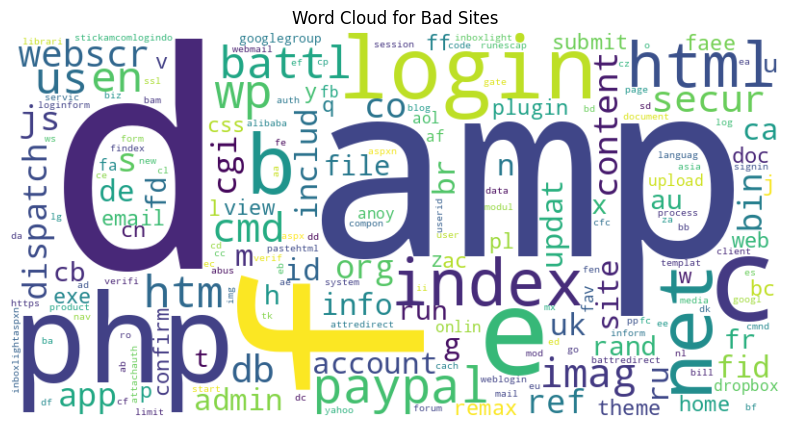

In [ ]:
# Plot word cloud for bad sites
plot_wordcloud(bad_text, title='Word Cloud for Bad Sites')

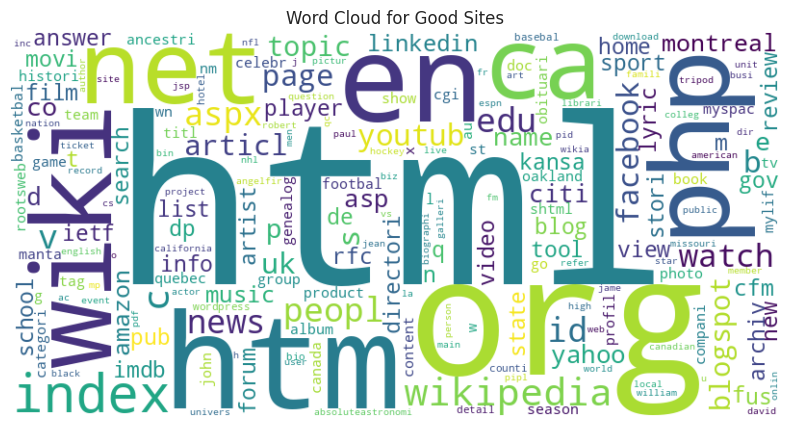

In [ ]:
# Plot word cloud for good sites
plot_wordcloud(good_text, title='Word Cloud for Good Sites')

### Visualizing redirect links on websites
This section involves plotting a network graph on existing redirect links on a website. For example, there may be more than 2 buttons on a webpage that would redirect users to other malicious sites.

For this purpose, Chrome WebDriver would be implemented to automate user interactions with webpages such as form filling, clicking buttons, and navigating through webpages. In general use, Chrome WebDriver is mostly used in testing the operation of webpages.

NOTE: For this to function, # make sure to install the appropriate Chrome WebDriver version that corresponds to your current Chrome version at https://chromedriver.chromium.org/getting-started

In [ ]:
# Instantiate a chrome webdriver object
browser = webdriver.Chrome() # might need to specify the path of the chrome extension you have downloaded from the linked website above

We need to make a list of the specific website we would want to scrape as per below:

In [ ]:
url_list = {'https://www.google.com/'} # for example, let's use the Google search page
links_with_text = []

After that, we will implement tools from the BeautifulSoup package that extracts data out from markup languages such as HTML and XML from the sites instantiated in the Chrome WebDriver object

In [ ]:
for url in url_list:
    browser.get(url)
    beautiful_soup = BeautifulSoup(browser.page_source, "html.parser")
    for line in beautiful_soup.find_all('a'): # find all anchor tag elements in HTML
        href = line.get('href') # get the hyperlink associated with the anchor tag
        links_with_text.append([url, href]) # adds hyperlinks scraped from the url

Once the all the redirect links within a website is obtained, we will need to turn the links_with_url list into a dataframe to be visualized later.

In [ ]:
url_df = pd.DataFrame(links_with_text, columns=["from", "to"])
url_df.head()

,from,to
0,https://www.google.com/,https://mail.google.com/mail/&ogbl
1,https://www.google.com/,https://www.google.com/imghp?hl=en&ogbl
2,https://www.google.com/,https://www.google.com.my/intl/en/about/products
3,https://www.google.com/,https://accounts.google.com/ServiceLogin?hl=en...
4,https://www.google.com/,https://www.google.com/setprefs?sig=0_nwBaczoW...


Finally, to visualize the redirect links associated with a specific web page, we will use the Networkx method to draw a network graph as per below:

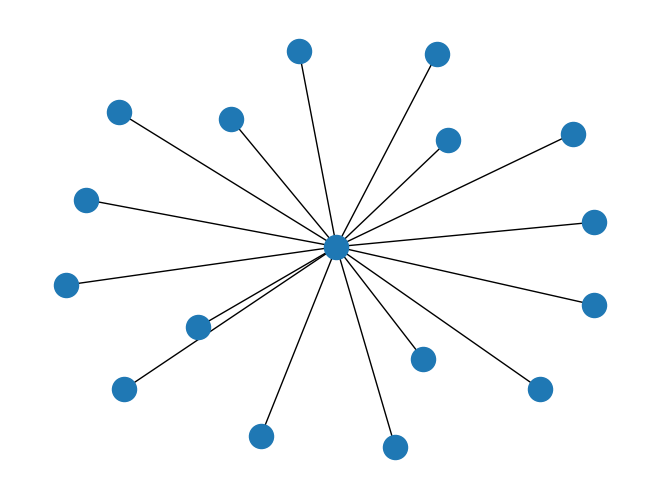

In [ ]:
network_graph = nx.from_pandas_edgelist(url_df, source="from", target="to")
nx.draw(network_graph, with_labels=False)

## E: EXPLORE

### Exploratory Data Analysis

In [ ]:
# Visualize the frequency of top level domains (TLDs) for good vs bad URLs
top_tlds_phish = bad_sites['URL'].apply(lambda x: x.split('.')[-1])
top_tlds_good = good_sites['URL'].apply(lambda x: x.split('.')[-1])

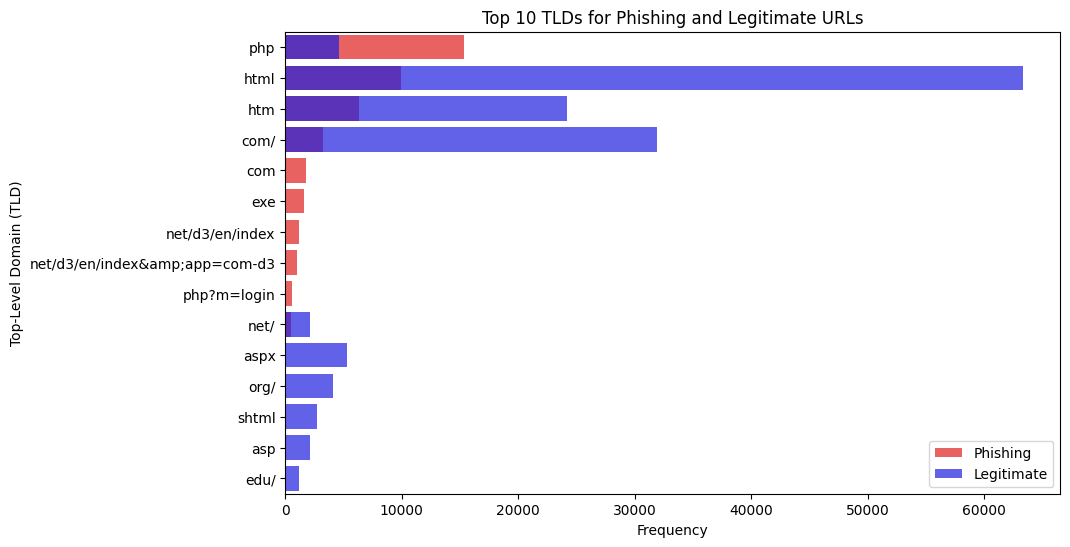

In [ ]:
# Plot histogram of good vs bad TLDs
plt.figure(figsize=(10, 6))
sns.countplot(y=top_tlds_phish, order=top_tlds_phish.value_counts().index[:10], color='red', alpha=0.7, label='Phishing')
sns.countplot(y=top_tlds_good, order=top_tlds_good.value_counts().index[:10], color='blue', alpha=0.7, label='Legitimate')

plt.title('Top 10 TLDs for Phishing and Legitimate URLs')
plt.xlabel('Frequency')
plt.ylabel('Top-Level Domain (TLD)')
plt.legend()
plt.show()

In [ ]:
# Statistical Analysis
# Calculate the mean URL length for phishing and legit URLs
mean_url_length_phishing = bad_sites['URL'].apply(len).mean()
mean_url_length_legitimate = good_sites['URL'].apply(len).mean()

print("Mean URL length (phishing):", mean_url_length_phishing)
print("Mean URL length (legitimate):", mean_url_length_legitimate)

Mean URL length (phishing): 71.05616847041532
Mean URL length (legitimate): 45.76827514590338


In [ ]:
# Further statistical explaination
url_length_stats = phish_data.groupby('Label')['URL'].apply(lambda x: x.str.len().describe())
print("URL Length Statistics:")
print(url_length_stats)

URL Length Statistics:
Label       
bad    count    114299.000000
       mean         71.056168
       std          74.590769
       min           1.000000
       25%          30.000000
       50%          47.000000
       75%          82.000000
       max        2307.000000
good   count    392897.000000
       mean         45.768275
       std          24.641324
       min           1.000000
       25%          30.000000
       50%          40.000000
       75%          56.000000
       max        1025.000000
Name: URL, dtype: float64


- From this we can see that URL length of phishing site appears to be longer than legitimate site
- While correlation doesn't equal causation, there are some insightful takeaways that we can think about based on this observation:

    - Legitimate URLs might be typically shorter and have a consistent structure, whereas phishing URLs can be longer due to added random characters or subdomains.
    - Phishing URLs may contain longer parameters or query strings to capture data or redirect users, contributing to increased length.
    - Phishers may use long URL to hide the doubtful or suspicious part in the address bar.

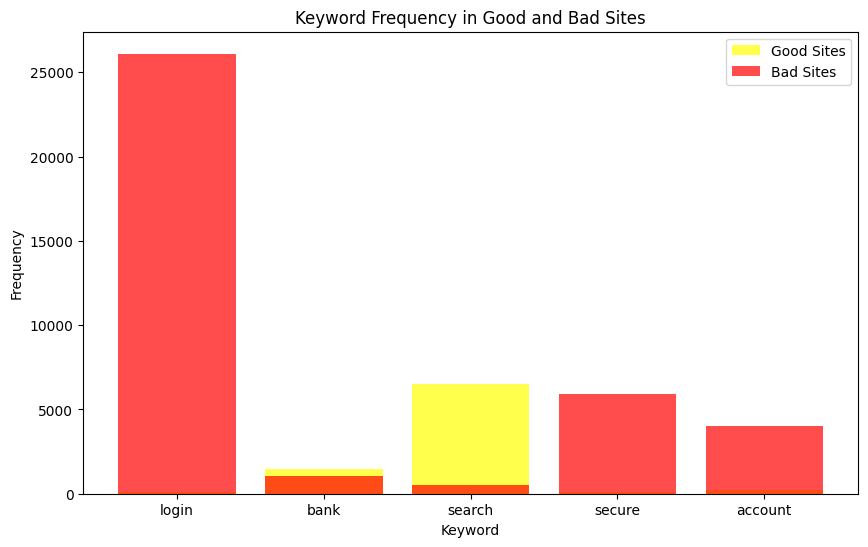

In [ ]:
# Function to count the frequency of keywords in URLs
def count_keywords(urls, keyword):
    return sum(url.count(keyword) for url in urls)

# Keywords of interest (change whenever necessary)
keywords = ['login', 'bank', 'search', 'secure', 'account']

# Count keyword frequencies in good and bad sites
keyword_counts_good = {keyword: count_keywords(good_sites['URL'], keyword) for keyword in keywords}
keyword_counts_bad = {keyword: count_keywords(bad_sites['URL'], keyword) for keyword in keywords}

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(keyword_counts_good.keys(), keyword_counts_good.values(), color='yellow', alpha=0.7, label='Good Sites')
plt.bar(keyword_counts_bad.keys(), keyword_counts_bad.values(), color='red', alpha=0.7, label='Bad Sites')
plt.title('Keyword Frequency in Good and Bad Sites')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.legend()
plt.show()

- Keywords like "login", "bank", "secure", and "account" are found mostly in phishing links while the keyword "search" is found mostly in legitimate links.

#### Special Character Count

Mean Special Character Count (phishing): 9.096580022572375
Mean Special Character Count (legitimate): 6.4682728552266875


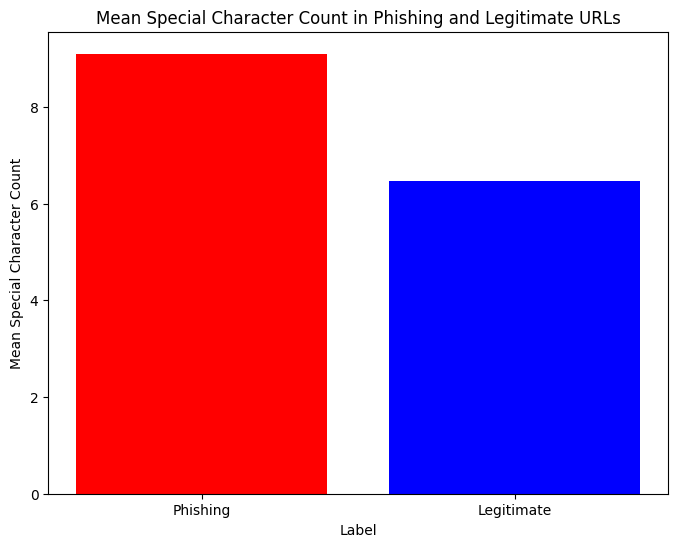

In [ ]:
# Define function to count special characters in a URL
def count_special_characters(url):
    special_characters = set(string.punctuation)  # All special characters
    return sum(1 for char in url if char in special_characters)

# Count special characters in phishing and legitimate URLs
phish_data['special_char_count'] = phish_data['URL'].apply(count_special_characters)
special_char_counts_phishing = phish_data[phish_data['Label'] == 'bad']['special_char_count']
special_char_counts_legitimate = phish_data[phish_data['Label'] == 'good']['special_char_count']

# Compare the mean special character count between phishing and legitimate URLs
mean_special_char_count_phishing = special_char_counts_phishing.mean()
mean_special_char_count_legitimate = special_char_counts_legitimate.mean()

print("Mean Special Character Count (phishing):", mean_special_char_count_phishing)
print("Mean Special Character Count (legitimate):", mean_special_char_count_legitimate)

# Create a bar plot to compare mean special character count for phishing and legitimate URLs
plt.figure(figsize=(8, 6))
plt.bar(['Phishing', 'Legitimate'], [mean_special_char_count_phishing, mean_special_char_count_legitimate], color=['red', 'blue'])
plt.title('Mean Special Character Count in Phishing and Legitimate URLs')
plt.xlabel('Label')
plt.ylabel('Mean Special Character Count')
plt.show()

## M: MODEL

In [ ]:
from sklearn.model_selection import train_test_split # spliting the data between feature and target
# algo used to detect
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB #
from xgboost import XGBClassifier

from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

# CountVectorizer
- The CountVectorizer is employed to convert a collection of text documents into a vector representation based on the frequency of individual terms or tokens



In [ ]:
# Create cv object
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [ ]:
# Transform all text which we tokenize and stemed
feature = cv.fit_transform(phish_data.text_sent)

In [ ]:
# Convert sparese matrix into array to print transformed features
feature[:5].toarray()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])



*   Splitting Data



In [ ]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)


# **Logistic Regression**

*  Logistic Regression, a classification algorithm in Machine Learning, estimates the probability of a binary dependent variable. This variable typically represents outcomes coded as 1 (e.g., success) or 0 (e.g., failure). In essence, the logistic regression model predicts the probability P(Y=1) based on input features X




In [ ]:
# Create LR object
LR = LogisticRegression()

In [ ]:
LR.fit(trainX,trainY)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
LR.score(testX,testY)

0.964897199504728

** Logistic Regression gives 96% accuracy. We will then compare which model performs the best

In [ ]:
# Store scores in a dict
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(LR.score(testX,testY),3)


Training Accuracy : 0.9785907880451212
Testing Accuracy : 0.964897199504728

Classification Report

              precision    recall  f1-score   support

         Bad       0.88      0.96      0.92     26015
        Good       0.99      0.97      0.98    100784

    accuracy                           0.96    126799
   macro avg       0.93      0.96      0.95    126799
weighted avg       0.97      0.96      0.97    126799


Confusion Matrix


<Axes: >

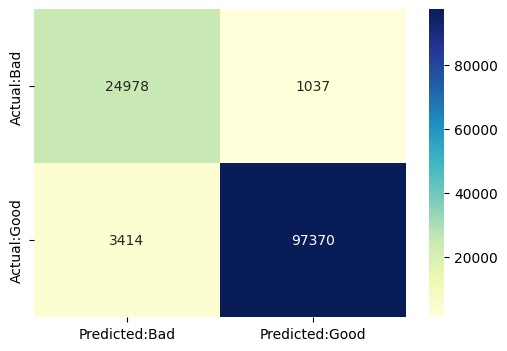

In [ ]:
print('Training Accuracy :',LR.score(trainX,trainY))
print('Testing Accuracy :',LR.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(LR.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nClassification Report\n')
print(classification_report(LR.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nConfusion Matrix')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# **MultinomialNB**

*   Multinomial Naive Bayes is commonly used for Natural Language Processing (NLP) tasks. The Naive Bayes Classifier Algorithm relies on Bayes’ theorem, assuming that features are conditionally independent
* In the context of phishing website detection, URLs can be represented as sequences of characters or words and Multinomial NB can efficiently handle such data by identifying pattterns indictive of phishing behaviour within URLs



In [ ]:
# Creating MultinomialNB object
Mnb = MultinomialNB()

In [ ]:
Mnb.fit(trainX,trainY)

MultinomialNB()

In [ ]:
Mnb.score(testX,testY)

0.95891923437882

** MultinomialNB gives a 95% accuracy

In [ ]:
Scores_ml['MultinomialNB'] = np.round(Mnb.score(testX,testY),2) #store in the scores dict


Training Accuracy : 0.9755518576644926
Testing Accuracy : 0.95891923437882

Classification Report

              precision    recall  f1-score   support

         Bad       0.89      0.92      0.91     27279
        Good       0.98      0.97      0.97     99520

    accuracy                           0.96    126799
   macro avg       0.93      0.95      0.94    126799
weighted avg       0.96      0.96      0.96    126799


Confusion Matrix


<Axes: >

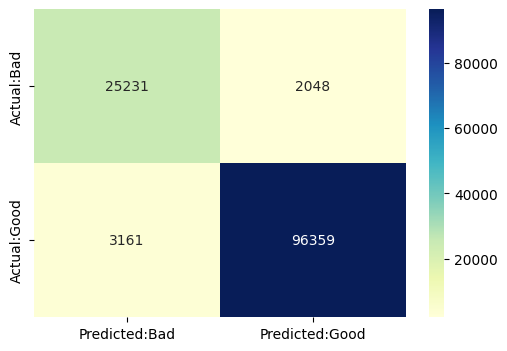

In [ ]:
print('Training Accuracy :',Mnb.score(trainX,trainY))
print('Testing Accuracy :',Mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(Mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nClassification Report\n')
print(classification_report(Mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nConfusion Matrix')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# **XGBoost**
* XGBoost has the capacity to effectively handle tabular data, making it suitable for a dataset with URL strings and binary labels.
* It's ensemble learning approach empowers it to discern subtle patterns within the data, enhancing the model's accuracy in identifying phishing websites.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert class labels ('bad' and 'good') into numeric format
label_encoder = LabelEncoder()
trainY_encoded = label_encoder.fit_transform(trainY)
testY_encoded = label_encoder.transform(testY)

In [ ]:
# Creating XGBoost classifier
xgb = XGBClassifier()

In [ ]:
xgb.fit(trainX,trainY_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predict the labels for the test set
y_pred_encoded = xgb.predict(testX)

# Decode the predicted labels back into their original categorical format
y_pred = label_encoder.inverse_transform(y_pred_encoded)

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
xgb_score = accuracy_score(testY, y_pred)
print('Accuracy:', xgb_score)

Accuracy: 0.9264189780676504


** XGBoost gives accuracy of 92%

In [ ]:
Scores_ml['XGBoost'] = np.round(xgb_score,2)

Training Accuracy: 0.9272286584804822
Testing Accuracy: 0.9264189780676504
Classification Report:
              precision    recall  f1-score   support

         bad       0.96      0.70      0.81     28392
        good       0.92      0.99      0.95     98407

    accuracy                           0.93    126799
   macro avg       0.94      0.85      0.88    126799
weighted avg       0.93      0.93      0.92    126799



<Axes: >

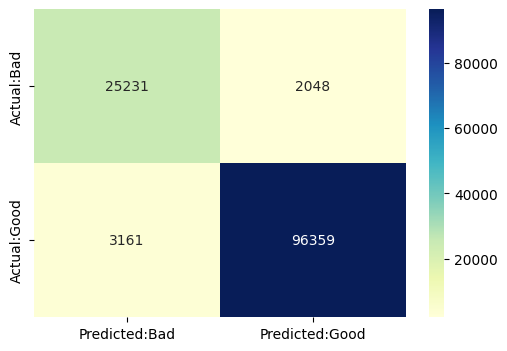

In [ ]:
# Calculate training accuracy
train_accuracy = accuracy_score(trainY, label_encoder.inverse_transform(xgb.predict(trainX)))

# Calculate testing accuracy
test_accuracy = accuracy_score(testY, y_pred)

# Print training and testing accuracy
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

# Generate confusion matrix
conf_mat = confusion_matrix(testY, y_pred)

# Print classification report
# Print classification report
print("Classification Report:")
print(classification_report(testY, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

Now that we have all 3 models trained, we will do comparison of models to see which model performs best for the given data

<Axes: ylabel='Accuracy'>

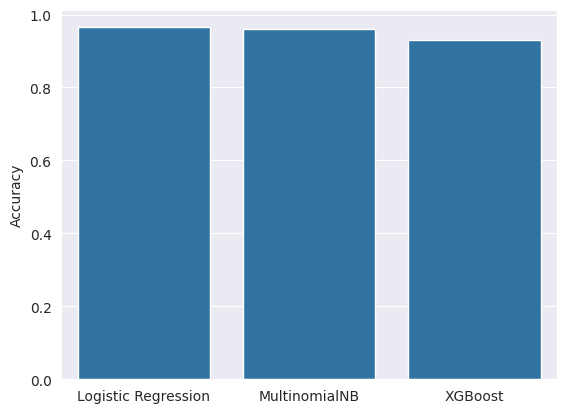

In [ ]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.Accuracy)

The high accuracy achieved by logistic regression and multinomial naive bayes despite their simplicity indicates that the dataset may have a linear or relatively simple underlying structure. Let's have a closer look on the difference between them

<ipython-input-48-d2b83c209c55>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Logistic Regression', 'Multinomial NB'],


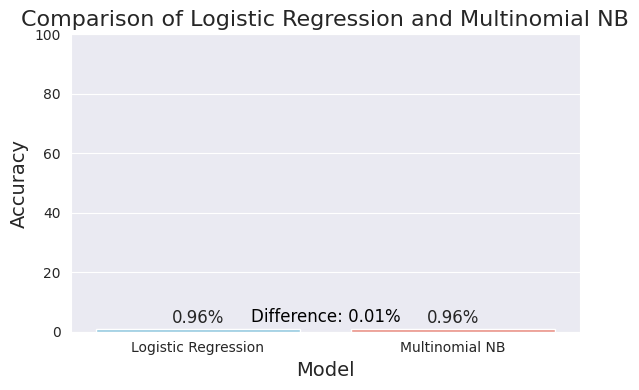

In [ ]:
# Accuracy scores of logistic regression and multinomial naive Bayes
logreg_accuracy = Scores_ml['Logistic Regression']
mnb_accuracy = Scores_ml['MultinomialNB']

# Calculate the percentage difference in accuracy
percentage_difference = abs(logreg_accuracy - mnb_accuracy)

# Plotting the paired bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=['Logistic Regression', 'Multinomial NB'],
            y=[logreg_accuracy, mnb_accuracy],
            palette=['skyblue', 'salmon'])

# Accuracy values
for i, accuracy in enumerate([logreg_accuracy, mnb_accuracy]):
    plt.text(i, accuracy + 0.5, f'{accuracy:.2f}%', ha='center', va='bottom', fontsize=12)

# Percentage difference
plt.text(0.5, (logreg_accuracy + mnb_accuracy) / 2 + 1,
         f'Difference: {percentage_difference:.2f}%',
         ha='center', va='bottom', fontsize=12, color='black')

# Labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of Logistic Regression and Multinomial NB', fontsize=16)
plt.ylim(0, 100)  # Set y-axis limit

# Show plot
plt.tight_layout()
plt.show()

Logistic regression is chosen as it provides direct interpretability of coefficients, which can be valuable when with small number of features. We can easily interpret how each URL contributes to the prediction of the label (good/bad)

# **Pipeline using Logistic Regression**

In [ ]:
pipeline_Ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())


In [ ]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)


In [ ]:
pipeline_Ls.fit(trainX,trainY)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [ ]:
pipeline_Ls.score(testX,testY)


0.9650785889478624

Training Accuracy : 0.9786775395179247
Testing Accuracy : 0.9650785889478624

Classification Report

              precision    recall  f1-score   support

         Bad       0.88      0.96      0.92     25938
        Good       0.99      0.97      0.98    100861

    accuracy                           0.97    126799
   macro avg       0.93      0.96      0.95    126799
weighted avg       0.97      0.97      0.97    126799


Confusion Matrix


<Axes: >

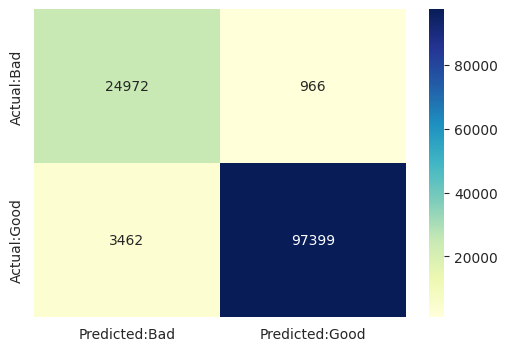

In [ ]:
print('Training Accuracy :',pipeline_Ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_Ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_Ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nClassification Report\n')
print(classification_report(pipeline_Ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nConfusion Matrix')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

** With the pipeline in logistic regression, we get an accuracy of 98% in detecting malicious URLs.

In [ ]:
# save the trained machine learning models to a file in a binary format
import pickle

In [ ]:
pickle.dump(pipeline_Ls,open('phishing.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9650785889478624


In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
# predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']
